# "Thy algorithm shalt not bear false witness": An Evaluation of Multiclass Debiasing Methods on Word Embeddings


This is the code to support the paper ""Thy algorithm shalt not bear false witness": An Evaluation of Multiclass Debiasing Methods on Word Embeddings"
 It shows, which experiments and debiasing techniques are applied to word embedding word2vec.
The approaches are namely: 

Debiasing approaches: 
*   Conceptor Debiasing
*   Hard Debiasing
*   softWEAT

Evaluation Metrics: 
*   Relative Negative Sentiment Bias(RNSB) Metric
*   Mean Average Cosine Similarity (MAC) Metric
*   Word Association Evaluation Test (WEAT) effect size Metric

This Notebook refers to the contextNet embeddings.

# Import packages

In [1]:
#Import needed Packages
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
import torch
import matplotlib.pyplot as plt
from scipy.linalg import null_space as ns
from statistics import mean
from scipy import stats
import warnings
from itertools import combinations

In [2]:
def loadConceptNetVectors():
    embeddings_dict = {}
    with open("FILEPATH\\numberbatch-en.txt", 'r', encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            if isfloat(values[1]):
                vector = np.asarray(values[1:], "float32")
                if len(vector) != 300:
                    print('INVALID LENGTH', len(vector), word)
                else:
                    embeddings_dict[word] = vector
                #print(word)
    return embeddings_dict

In [3]:
def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False


In [4]:
model = loadConceptNetVectors()

INVALID LENGTH 1 516782


# Data

Below the data for the debaising and evaluation methods are defined.

The sets of words concerning a particular attribute class are taken from Popovic, Lemmerich and Strohmaier (2020).

In [5]:
sets = {'pleasant': ['caress', 'freedom', 'health', 'love', 'peace', 'cheer', 'friend', 'heaven', 'loyal', 'pleasure', 'diamond', 'gentle', 'honest', 'lucky', 'rainbow', 'diploma', 'gift', 'honor', 'miracle', 'sunrise', 'family', 'happy', 'laughter', 'paradise', 'vacation', 'joy', 'wonderful'],
        'unpleasant': ['abuse', 'crash', 'filth', 'murder', 'sickness', 'accident', 'death', 'grief', 'poison', 'stink', 'assault', 'disaster', 'hatred', 'pollute', 'tragedy', 'divorce', 'jail', 'poverty', 'ugly', 'cancer', 'kill', 'rotten', 'vomit', 'agony', 'prison', 'terrible', 'horrible'],
        'instruments': ['bagpipe', 'cello', 'guitar', 'lute', 'trombone', 'banjo', 'clarinet', 'harmonica', 'mandolin', 'trumpet', 'bassoon', 'drum', 'harp', 'oboe', 'tuba', 'bell', 'fiddle', 'harpsichord', 'piano', 'viola', 'bongo', 'flute', 'horn', 'saxophone'],
        'weapons': ['arrow', 'club', 'gun', 'missile', 'spear', 'dagger', 'harpoon', 'pistol', 'sword', 'blade', 'dynamite', 'hatchet', 'rifle', 'tank', 'bomb', 'firearm', 'knife', 'shotgun', 'teargas', 'cannon', 'grenade', 'mace', 'slingshot', 'whip'],
        'career': ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career'],
        'family': ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives'],
        'science': ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy'],
        'art': ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture'], 
        'intellectual_words': ['resourceful', 'inquisitive', 'sagacious', 'inventive', 'adaptable', 'intuitive', 'analytical', 'imaginative', 'shrewd', 'thoughtful', 'smart', 'clever', 'brilliant', 'logical', 'intelligent', 'apt', 'genius', 'wise', 'stupid', 'dumb', 'dull', 'clumsy', 'foolish', 'naive', 'unintelligent'],
        'appearance_words': ['alluring', 'voluptuous', 'blushing', 'homely', 'plump', 'sensual', 'gorgeous', 'slim', 'bald', 'athletic', 'fashionable', 'stout', 'ugly', 'muscular', 'slender', 'feeble', 'handsome', 'healthy', 'attractive', 'fat', 'weak', 'thin', 'pretty', 'beautiful', 'strong'], 
        'shy': ['soft', 'quiet', 'compromising', 'rational', 'calm', 'kind', 'agreeable', 'servile', 'pleasant', 'cautious', 'friendly', 'supportive', 'nice', 'mild', 'demure', 'passive', 'indifferent'],
        'aggressive': ['shrill', 'loud', 'argumentative', 'irrational', 'angry', 'abusive', 'obnoxious', 'controlling', 'nagging', 'brash', 'hostile', 'mean', 'harsh', 'sassy', 'aggressive', 'opinionated', 'domineering'],
        'competent': ['competent', 'productive', 'effective', 'ambitious', 'active', 'decisive', 'strong', 'tough'], 'incompetent': ['incompetent', 'unproductive', 'ineffective', 'passive', 'indecisive', 'weak', 'gentle', 'timid'],
        'likeable': ['agreeable', 'fair', 'honest', 'trustworthy', 'selfless', 'accommodating'],
        'unlikeable': ['abrasive', 'conniving', 'manipulative', 'dishonest', 'selfish', 'pushy']}

In [6]:
attributes = sets.copy()

In order to establish a common base of identity terminology of groups used to debias the word embedding, an equality set of words is built. The choice for equality sets stems from the fact that hard debiasing requires equality sets to debias. With the use of the same equality set in each method, a more meaningful comparison can be made. 

The equality set was built by hand, with some notions taken from Manzini, Lim, Tsvetkov and Black (2019) equality sets.

In [7]:
sets['judaism_words'] = ['judaism', 'jew','jews','synagogue','synagogues', 'torah', 'rabbi', 'rabbis', 
                         'abraham', 'star', 'shabbat']
sets['christianity_words'] = ['christianity','christian','christians','church','churches','bible','priest','priests',
                             'jesus','cross','easter']
sets['islam_words'] = ['islam','muslim','muslims','mosque','mosques','quran','imam','imams','muhammad',
                        'hilal','ramadan']

In [8]:
equality_sets = [
        ["judaism", "christianity", "islam"],
        ["jew", "christian", "muslim"],
        ["jews", "christians", "muslims"],
        ["synagogue", "church", "mosque"],
        ["synagogues", "churches", "mosques"],
        ["torah", "bible", "quran"],
        ["rabbi", "priest", "imam"],
        ["rabbis", "priests", "imams"],
        ["abraham", "jesus", "muhammad"],
        ["star", "cross", "hilal"],
        ["shabbat", "easter", "ramadan"],
    
]

# Bias Evaluations

In [9]:
Results = {}

In [10]:
def ttest_p(nonDB_target_eval, target_eval):
    '''
    nonDB_target_eval: first distribution
    target_eval: second distribution
    returns p value of a one taile dt test between the two distributions
    '''
    diff = []
    #differences between non debias and this method
    for i in range(len(target_eval)):
        diff.append(target_eval[i]- nonDB_target_eval[i])    
    diff = np.array(diff)
    std = np.std(diff)
    mean = np.mean(diff)
    st_error = std/(np.sqrt(len(diff)))
    test_stat = mean/st_error
    p_val = stats.t.sf(np.absolute(test_stat),df=len(diff)-1)
    print('test stat', test_stat)
    print('p ', p_val )
    return p_val

## Relative Negative Sentiment Bias
The first evaluation method will be the RNSB metric. It imitates the results, which would be given to a downstream application.
The relative negative sentiment bias is an approach proposed by Sweeney and Najafan (2019) in order to offer insights on the effect of biased word embeddings through downstream applications. Its framework involves training a logistic classifier to predict the positive or negative sentiment of a given word. The classifier is trained on unbiased sentiment words, which are encoded via the word embedding to be investigated. Sweeney and Najafan then encode demographic identity terms and predict their respective negative sentiment probability. These results are used to form a probability distribution P. The Relative Negative Sentiment Bias (RNSB) is then defined "as the KL
divergence of P from U, where U is the uniform
distribution". 

The RNSB metric will be calculated for each debiasing method. To  intrepret this metric, Sweeney and Najafian state that "Our RNSB metric captures the distance, via KL divergence, between the current distribution of negative sentiment and the fair uniform distribution. So the more fair a word embedding model with respect to sentiment bias, the lower the RNSB metric."

*(Sweeney, C., & Najafian, M. (2019, July). A Transparent Framework for Evaluating Unintended Demographic Bias in Word Embeddings. In Proceedings of the 57th Annual Meeting of the Association for Computational Linguistics (p. 1664).)*

In [11]:
def readInReview(reviewName):
    firstReview = open(reviewName, "r")
    review = firstReview.read()
    #Each list element is a word or title
    reviewList = re.split(r'\n', review)
    #remove introduction to dataset
    count = 0
    for x in reviewList:
        if x.startswith(';'):
            count +=1
        else:
            break
    reviewList = reviewList[count:]
    return reviewList

In [12]:
def create_embeddings(model_Encoding,review):
    embedding_matrix = []
    for x in review:
        if x in model:
            embedding_matrix.append(model_Encoding(x))
    embedding_matrix = np.array(embedding_matrix)
    return embedding_matrix

In [13]:
def calculateRNSB(results):
    negProbResults = []
    negProbSum = 0
    for x in results:
        negProbResults.append(x[0])
        negProbSum += x[0]

    normalizedResults = []
    for i in range(len(results)): 
        normalizedResults.append(negProbResults[i]/negProbSum)
        
    #KL(P || Q) = sum x in X P(x) * log(P(x) / Q(x))
    RNSB = 0
    Q = 1/len(normalizedResults)
    for x in normalizedResults:
        RNSB += x * np.math.log((x / Q))
    return RNSB

In [15]:
def RNSB_Evaluation(model_Encoding,identity_words,p_val = True):
    '''
    model_encoding: methodcall to get a word embedding for a word
    identity_words: equaluty sets to be tested
    p_val: whether a one tailed t test on the distribution of the values should be performed
    returns: RNSB score, p value and average RNSB scores for each equality set
    
    '''
    warnings.filterwarnings("ignore")
    #Train logistic classifier on unbiased positive /negative sentiment words
    reviewNeg = readInReview("opinion-lexicon-English\\negative-words.txt")
    neg = create_embeddings(model_Encoding,reviewNeg)
    targetN = np.zeros(np.size(neg,0))
    reviewPos = readInReview("opinion-lexicon-English\\positive-words.txt")
    pos = create_embeddings(model_Encoding,reviewPos)
    targetP = np.ones(np.size(pos,0))
    #print('length of neg targets', len(targetN))
    #print('length of pos targets', len(targetP))
    embed = np.concatenate((pos,neg))
    target = np.concatenate((targetP,targetN))
    #Train, (Validation) and Test set 
    rnsb_values = []
    stats = np.zeros(len(identity_words))
    for n in range (0, 20):
        itrain, itest = train_test_split(range(embed.shape[0]), test_size=0.2)

        X_train = embed[itrain, :]
        X_test = embed[itest, :]
        y_train = target[itrain]
        y_test = target[itest]


        logisticReg = LogisticRegression()
        logisticReg.fit(X_train,y_train)
        logpredy = logisticReg.predict(X_test)
        #print("Accuracy:",metrics.accuracy_score(y_test, logpredy))
        #print("Recall:", metrics.recall_score(y_test, logpredy))
        #print("Precision:", metrics.precision_score(y_test, logpredy))
        #print("F1: ", metrics.f1_score(y_test, logpredy))
        RNSB = []
        for iset in identity_words: 
            identity_embed= []
            for i in iset:
                if not model_Encoding(i) == 'None':
                    identity_embed.append(model_Encoding(i))
            identity_pred = logisticReg.predict_proba(identity_embed)
            temp = calculateRNSB(identity_pred)
            RNSB.append(temp)
            #print('RNSB ', temp, 'of ', iset )
        RNSB = np.array(RNSB)
        rnsb_values.append(np.mean(RNSB))
        stats = np.add(stats,RNSB)
    
    stats = np.divide(stats,20)
    if p_val:
        _,RNSBnonDB_target_eval,_ = RNSB_Evaluation(encode_nondebias,equality_sets,p_val = False)
        p_val = ttest_p(RNSBnonDB_target_eval, stats)
    else:
        p_val = 0
    print(p_val)
    score = mean(rnsb_values)
    print('average over 20 ', score)
    return score, stats, p_val


## Mean Average Cosine Similarity (MAC)
The second evalutation method is the Mean Average Cosine Similarity (MAC) as proposed by Manzini et al. The method originates from the notion of the WEAT test implemented below, but allows for quantification of multiclass bias.

The approach uses Target sets T, which are identity terms for a protected group, and thus inherently carry some bias, and attribute sets A containing terms that should not be linked to the target sets above (pleasent, unpleasent. The MAC metric is acquired by calculating the mean over the cosine distances between each element in a particular set T to each element in a particular set A. This is repeated for each set T with respect to each set A. The MAC is then the average result over all sets.

The cosine distance ranges from 0 to 2, 0 indicating that the vectors are the same and 2 indicating that the vectors have maximum cosine distance. Thus, to interpret the MAC metric, one should ideally expect a MAC value of close to 1. This would indicate that the target sets are as close to an attribute set, as they are distant from it.

*(Manzini, T., Lim, Y. C., Tsvetkov, Y., & Black, A. W. (2019). Black is to criminal as caucasian is to police: Detecting and removing multiclass bias in word embeddings. arXiv preprint arXiv:1904.04047.)*

In [16]:
def multiclass_evaluation(word_encoding, calculate_p_val = True):
    '''
    word_encoding : methodcall to get a word embedding for a word
    calculate_p_val : whether a p value for the one tailed t test should be caluclated 
    returns MAC score, p value, individual MAC scores for each equality sets
    '''
    targets_eval = []
    for targetSet in equality_sets:
        for target in targetSet:
            if word_encoding(target) != 'None':
                for attributeSet in attributes:
                    res = 0
                    count = 0
                    for a in attributeSet: 
                        if word_encoding(a)!= 'None':
                            t_embed = word_encoding(target)
                            a_embed = word_encoding(a)
                            temp = cosine(t_embed,a_embed)
                            res+= temp
                            count += 1
                            #print(f'{target} and {a} : {temp}')
                            
                    targets_eval.append((res/count))
    if calculate_p_val: 
        _,_,nonDB_target_eval = multiclass_evaluation(encode_nondebias, False)
        p_val = ttest_p(nonDB_target_eval,targets_eval)
    else: 
        p_val = 0
    m_score = np.mean(targets_eval)
    return m_score, p_val, targets_eval

## Word Evaluation Association Test (WEAT) Effect Size
The WEAT also utilizes target and attribute sets as defined above. The WEAT considers two target and two attribute sets simultaeneously. It tests the association between one target and attribute set, relative to the association of the other target and attribute set. "null hypothesis is that there is no difference between the two sets of target
words in terms of their relative similarity to the two sets of attribute words"


To perform the WEAT test, the mean cosine similarity of an element in target set T1 to all elements in attribute set A2 is subtracted from the mean cosine similarity to all elements in attribute set A1. The sum of this is taken for all elements of T1. From this the sum for all elements in T2 is subtracted. This value is defined as the test statistic. 

To obtain the effect size, which is "a normalized measure of how separated the two distributions (of associations between the target and attribute) are" (Caliskan et al, 2017), the mean of the mean cosine similarity of each target of a target set T1 to each attribute set is taken. From this the mean of the mean cosine similarity of each target of a target set T2 to each attribute set is subtracted. To normalize this, this value is devided by the standard deviation over the mean cosine distance of each target in T1 and T2 to attribute set A1 minus that to attribute set A2. 

The loewer the effect size d is, i.e. the closer to zero, the less bias can be recorded between the target and attribute sets.


*(Caliskan, A., Bryson, J. J., & Narayanan, A. (2017). Semantics derived automatically from language corpora contain human-like biases. Science, 356(6334), 183-186.)*

In [17]:
religion ={('islam_words', 'judaism_words'): [('likeable', 'unlikeable'), ('competent', 'incompetent'), 
                                                 ('shy', 'aggressive'), ('intellectual_words', 'appearance_words'),
                                                 ('family', 'career'), ('instruments', 'weapons'), 
                                                 ('pleasant', 'unpleasant'), ('science', 'art')], 
           
              ('islam_words', 'christianity_words'): [('likeable', 'unlikeable'), ('competent', 'incompetent'),
                                                      ('shy', 'aggressive'), ('intellectual_words', 'appearance_words'),
                                                      ('family', 'career'), ('instruments', 'weapons'), 
                                                      ('pleasant', 'unpleasant'), ('science', 'art')], 
           
              ('judaism_words', 'christianity_words'): [('likeable', 'unlikeable'), ('competent', 'incompetent'), 
                                                        ('shy', 'aggressive'), ('intellectual_words', 'appearance_words'),
                                                        ('family', 'career'), ('instruments', 'weapons'), 
                                                        ('pleasant', 'unpleasant'), ('science', 'art')]
          }

In [18]:
def WEAT_Effect_size(x,y,a,b):

        numerator = np.mean([h(w,a,b) for w in x]) - np.mean([h(w,a,b) for w in y])
        denominator = np.std([h(w,a,b) for w in x + y])
        return numerator/denominator

In [19]:
def h(w,A,B):
    meanA = np.mean([cosine(w,a) for a in A])
    meanB = np.mean([cosine(w,b) for b in B])
    return (meanA - meanB)

In [21]:
def WEAT_Average_Effect_size(embedding_meth, biasToBeTested):
    count = 0
    d_values = []

    for category_target_pair in biasToBeTested:
        cat_0 = [embedding_meth(c) for c in sets[category_target_pair[0]]]
        cat_1 = [embedding_meth(c) for c in sets[category_target_pair[1]]]
        for attribute_pair in biasToBeTested[category_target_pair]:
            att_0 = [embedding_meth(a) for a in sets[attribute_pair[0]]]
            att_1 = [embedding_meth(a) for a in sets[attribute_pair[1]]]
            d = WEAT_Effect_size(cat_0, cat_1, att_0, att_1)
            d_values.append(np.abs(d))
                
    return np.mean(d_values)

# Non-Debiased Word Embedding Evaluation

This is the Conceptnet model prior to any debiasing. It should perform the worst.
http://blog.conceptnet.io/posts/2019/conceptnet-numberbatch-19-08/

In [22]:
def encode_nondebias(word):
    if word in model:
        return model[word]
    return 'None'

In [23]:
relBias,RNSBnonDB_target_eval,p = RNSB_Evaluation(encode_nondebias,equality_sets, False) 

0
average over 20  0.022338587200976912


In [24]:
score,p2,t = multiclass_evaluation(encode_nondebias)

test stat nan
p  nan


In [25]:
weat = WEAT_Average_Effect_size(encode_nondebias, religion)

In [26]:
Results['Nondebias'] = [relBias, p, score,p2, weat]

## Debiasing via Concept Negator

Conceptor Debiasing (Karve, Ungar and Sedoc (2019))

In [27]:
def findNegatedConceptor(Z, aperture = 10):
    '''
    Find conceptor to debias with
    '''
    k = len(Z)
    Z_Trans = Z.transpose()
    C_1 = (1/k) * np.matmul(Z,Z_Trans)
    temp = (aperture**(-2)) * np.identity(300)
    C_2 = np.linalg.inv(np.add(C_1, temp))
    C = np.matmul(C_1,C_2)
    G = np.subtract(np.identity(300),C)
    return G

In [28]:
def encodeViaConceptorNegator(word):
    if word in model:
        word = model[word]
        word = word / np.linalg.norm(word)
        return np.matmul(negConceptor,word) 
    return 'None'

In [30]:
#Target Words 
Z = sets['judaism_words']+sets['christianity_words']+sets['islam_words']
Z = list(set(Z))
Z_embed = []
for z in Z:
    if z in model:
        Z_embed.append(model[z])
Z_embed = np.array(Z_embed)
Z_embed  = Z_embed.transpose()
negConceptor = findNegatedConceptor(Z_embed)

In [31]:
relBias,_,p = RNSB_Evaluation(encodeViaConceptorNegator,equality_sets)

0
average over 20  0.02223597023922132
test stat -2.1087088452750127
p  0.03058744230543485
0.03058744230543485
average over 20  0.0077765203557548295


In [32]:
score,p2,t = multiclass_evaluation(encodeViaConceptorNegator)

test stat 2.7129199637036367
p  0.003443719362742512


In [33]:
weat = WEAT_Average_Effect_size(encodeViaConceptorNegator, religion)

In [34]:
Results['Conceptor_Debias'] = [relBias, p,score,p2 ,weat]

## Debiasing via Hard Debiasing

Debiasing via Hard Debiasing
Hard Debiasing Manzini et al. (2019) Adapted from :https://github.com/TManzini/DebiasMulticlassWordEmbedding

In [35]:
# Identify the Bias Subspace
# Taken and adapted from Mazini et als implementation

def identify_bias_subspace(def_sets, subspace_dim, embedding_dim):
    """
    Similar to bolukbasi's implementation at
    https://github.com/tolga-b/debiaswe/blob/master/debiaswe/debias.py
    vocab - dictionary mapping words to embeddings
    def_sets - sets of words that represent extremes? of the subspace
            we're interested in (e.g. man-woman, boy-girl, etc. for binary gender)
    subspace_dim - number of vectors defining the subspace
    embedding_dim - dimensions of the word embeddings
    """
    # calculate means of defining sets # calculate vectors to perform PCA
    means = {} 
    matrix = []
    for term_list in def_sets:
        wSet = []
        for w in term_list:
            if w in model: 
                wSet.append(model[w])

        set_vectors = np.array(wSet)
        means = np.mean(set_vectors, axis=0)
        diffs = set_vectors - means
        matrix.append(diffs)

    matrix = np.concatenate(matrix)

    pca = PCA(n_components=subspace_dim)
    pca.fit(matrix)

    return pca.components_


In [36]:
def project_onto_subspace(vector, subspace):
    v_b = np.zeros_like(vector)
    for component in subspace:
        v_b += np.dot(vector.transpose(), component) * component
    return v_b

In [37]:
def encodeHardDebias(word): 
    # is the word in the model vocab
    if word not in model: 
        return 'None'
    wordEmbed = model[word]
    
    #if the word should contain bias, i.e. is found in following sets: 
    eq_sets = equality_sets
    eq_set =[]
    for i in eq_sets:
        if word in i:
            eq_set = i
    # is the word in a set
    if len(eq_set) != 0:
        
    #embed the set, and simultaeneuosly compute the mean
        mean = np.zeros((300,))
        cleanEqSet = []    
        for w in eq_set:
            if w in model and not w == word:
                v = model[w]
                v = v / np.linalg.norm(v)
                mean += v
                cleanEqSet.append(v)
            elif w == word:
                wordEmbed = wordEmbed/np.linalg.norm(wordEmbed)
                mean += wordEmbed
        mean /= float(len(cleanEqSet))
        
        #bias subspace component of the mean
        mean_b = project_onto_subspace(mean, bias_subspace)
        upsilon = mean - mean_b
        v_b = project_onto_subspace(wordEmbed, bias_subspace)
        frac = (v_b - mean_b) / np.linalg.norm(v_b - mean_b)
        wordEmbed = upsilon + np.sqrt(1 - np.square(np.absolute(upsilon))) * frac
        return wordEmbed
    # if it should not contain any bias
    v_b = project_onto_subspace(wordEmbed, bias_subspace)
    wordEmbed = (wordEmbed - v_b) / np.linalg.norm(wordEmbed - v_b)

    return wordEmbed

In [38]:
#definite sets and equality sets
bias_subspace = identify_bias_subspace(equality_sets, 1, 300 )
#make bias subsapce 2d
if bias_subspace.ndim == 1:
    bias_subspace = np.expand_dims(bias_subspace, 0)
elif bias_subspace.ndim != 2:
    raise ValueError("bias subspace should be either a matrix or vector")

In [39]:
relBias,_,p = RNSB_Evaluation(encodeHardDebias,equality_sets)

0
average over 20  0.02232367971646843
test stat -2.2407341340713973
p  0.024471621311983733
0.024471621311983733
average over 20  4.3134371900243536e-06


In [40]:
score,p2,t = multiclass_evaluation(encodeHardDebias)

test stat -1.6277679618852339
p  0.05208588234222636


In [41]:
weat = WEAT_Average_Effect_size(encodeHardDebias, religion)

In [42]:
Results['Hard_Debias'] = [relBias, p, score, p2, weat]

# SoftWEAT

Popovic et al. (2020) Adapted from: https://github.com/RadomirPopovicFON/Joint-Multiclass-Debiasing-of-Word-Embeddings/tree/9c15ba7299599ccee6170ac6ec0d25cde95a3778

In [43]:
final_t = {}

In [44]:
thresh = 0.5

In [45]:
def WEAT(embedding_meth, biasToBeTested, threshold = thresh):
    to_debias_dict = {'islam_words': [], 'christianity_words':[], 'judaism_words':[]}
    d_values = []
    for category_target_pair in biasToBeTested:
        cat_0 = [embedding_meth(c) for c in sets[category_target_pair[0]]]
        cat_1 = [embedding_meth(c) for c in sets[category_target_pair[1]]]
        for attribute_pair in biasToBeTested[category_target_pair]:
            att_0 = [embedding_meth(a) for a in sets[attribute_pair[0]]]
            att_1 = [embedding_meth(a) for a in sets[attribute_pair[1]]]
            d = WEAT_Effect_size(cat_0, cat_1, att_0, att_1)
            print(f'{attribute_pair[0]} , {attribute_pair[1]}, {category_target_pair[0]}, {category_target_pair[1]} = {d}')
            d_values.append(abs(d))
            if np.abs(d) > threshold:
                if d > 0:
                    if attribute_pair[0] not in to_debias_dict[category_target_pair[0]]:
                        to_debias_dict[category_target_pair[0]].append(attribute_pair[0])
                    if attribute_pair[1] not in to_debias_dict[category_target_pair[1]]:
                        to_debias_dict[category_target_pair[1]].append(attribute_pair[1])
                else: 
                    if attribute_pair[1] not in to_debias_dict[category_target_pair[0]]:
                        to_debias_dict[category_target_pair[0]].append(attribute_pair[1])
                    if attribute_pair[0] not in to_debias_dict[category_target_pair[1]]:
                        to_debias_dict[category_target_pair[1]].append(attribute_pair[0]) 
    return to_debias_dict, np.mean(d_values)

In [46]:
#https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db
def find_closest_embeddings(embedding, n):
    temp = sorted(model.keys(), key=lambda word: cosine(model[word], model[embedding]))
    return temp[:n]

In [47]:
def similarity(word, w):
    return cosine(model[word], model[w])

In [48]:
def addNeighbourWords(classes, n):
    '''
    classes: target sets for Christianity, Islam, Judaism 
    n: number of neighbours
    returns n extra neighbours for each subclass
    '''
    ## Find neighbouring words
    newWords = {}
    for subclass in classes.keys(): 
        print('finding neighbouring words for ', subclass)
        for word in classes[subclass]: 
            print('finding neighbouring words for ', word)
            neighbours = find_closest_embeddings(word, n)
            for neighbour in neighbours:
                if neighbour not in newWords.keys():
                    newWords[neighbour] = [subclass]
                elif subclass not in newWords[neighbour]:
                    newWords[neighbour].append(subclass)
    print('Done finding words ....')
    for word in list(newWords.keys()):
        for subclasses in classes.keys():
            if word in classes[subclasses]:
                print(subclasses , ' ', word)
                if word in newWords:
                    del newWords[word]
    for word, value in newWords.items():
        if len(value) == 1:
            classes[value[0]].append(word)
        else: 
            print('duplicate : ', word, ' in ', value)
            best = 0
            bestClass = None
            for v in value:
                sum = 0
                c = 0 
                for w in classes[v]:
                    c+=1
                    sum += similarity(word,w)
                mean = sum/c
                if mean > best:
                    best = mean
                    bestClass = v
            print('duplicate : ', word, ' in ', value, ' put in ', bestClass, ' with ', best)
            classes[bestClass].append(word)
    print('Neighbours')
    for s in classes:
        print(s, len(classes[s]))
        print(classes[s])
    return classes

In [49]:
def embeddingsoftWEAT(word, classes, T = final_t):
    if word not in model: 
        return 'None'
    for sc in classes.keys():
        if word in classes[sc] and T[sc] != []:
            t = T[sc]
            word = np.array(model[word])
            word = np.append(word, 1)
            v =  np.dot(t, word)[0:-1]
            return v / np.linalg.norm(v)
    return model[word]

In [50]:
def WEATtest(embedding_meth, T, classes, biasToBeTested, threshold = thresh):
    d_values = []
    for category_target_pair in biasToBeTested:
        cat_0 = [embedding_meth(c,classes,T) for c in sets[category_target_pair[0]]]
        cat_1 = [embedding_meth(c,classes,T) for c in sets[category_target_pair[1]]]
        for attribute_pair in biasToBeTested[category_target_pair]:
            att_0 = [embedding_meth(a,classes,T) for a in sets[attribute_pair[0]]]
            att_1 = [embedding_meth(a,classes,T) for a in sets[attribute_pair[1]]]
            d = WEAT_Effect_size(cat_0, cat_1, att_0, att_1)
            d_values.append(abs(d))
 
    return np.mean(d_values)

In [51]:
def getT(debias_dict, all_attribute_words, classes, l):
    t = {'islam_words': [], 'christianity_words':[], 'judaism_words':[]}
    final_t = {}
    for s in debias_dict.keys():
        biasedAttr = debias_dict[s]
        print(biasedAttr, type(biasedAttr))
        targetWords = classes[s] 
        for w in all_attribute_words:
            if w in targetWords:
                targetWords.remove(w)
        targetWords = [model[w] for w in targetWords if w in model]
        meanTargetWord = np.mean(targetWords, axis = 0)
        meanAttSets = []
        for attset in biasedAttr:
            tempSet = [model[w] for w in sets[attset]]
            meanAttSets.append(np.mean(tempSet, axis = 0))
        meanMatrix = np.array(meanAttSets)
        null_space_vectors = ns(meanMatrix)
        temp = 100
        d_vals = []
        best = 1
        bestMat = None
        for n in range(temp):
            T = null_space_vectors[:,n] - meanTargetWord
            TI = np.identity(len(T)+1)
            for t_i, value in enumerate(T):
                TI[t_i, -1] = value * l 
            t[s] = TI
            d = WEATtest(embeddingsoftWEAT,t,classes, religion)
            #print('effect size d = ',d) 
            if d < best: 
                best = d
                bestMat = TI
            d_vals.append(d)
        final_t[s] = TI
    return final_t

In [52]:
def softWEAT(lamda):
    #get attribute sets to debias to
    debias_dict,_ = WEAT(encode_nondebias,religion)
    print(debias_dict)
    
    #establish target words and neighbours to debias
    classes = {}
    classes['islam_words'] = sets['islam_words'].copy()
    classes['christianity_words'] = sets['christianity_words'].copy()
    classes['judaism_words'] = sets['judaism_words'].copy()
    classes = addNeighbourWords(classes, 10)
    for s in classes:
        print(s, len(classes[s]))
        
    #list all words in each attribute set
    all_attribute_words = []
    for s in sets.keys():
        if s != 'christianity_words' and s!= 'islam_words' and s!= 'judaism_words':
            all_attribute_words.extend(sets[s])
    print('All Attribute Words', all_attribute_words)
    
    final_t = {}
    final_t = getT(debias_dict, all_attribute_words, classes,lamda)
    return final_t, classes

In [53]:
thresh = 0.5
final_t, classes = softWEAT(lamda= 0.5)

likeable , unlikeable, islam_words, judaism_words = -0.9856263440964548
competent , incompetent, islam_words, judaism_words = 1.3035998096564017
shy , aggressive, islam_words, judaism_words = 0.6048398303482232
intellectual_words , appearance_words, islam_words, judaism_words = 1.5246392743216168
family , career, islam_words, judaism_words = 0.3561610325250264
instruments , weapons, islam_words, judaism_words = 1.4271367595721247
pleasant , unpleasant, islam_words, judaism_words = 0.1517951817140258
science , art, islam_words, judaism_words = 0.3995852310902504
likeable , unlikeable, islam_words, christianity_words = -0.5336664478564374
competent , incompetent, islam_words, christianity_words = 1.421793005092937
shy , aggressive, islam_words, christianity_words = 0.27497027985875794
intellectual_words , appearance_words, islam_words, christianity_words = 0.9278409544133168
family , career, islam_words, christianity_words = 0.2807237113609414
instruments , weapons, islam_words, christia

['likeable', 'incompetent', 'appearance_words', 'weapons', 'unpleasant', 'science', 'unlikeable', 'intellectual_words', 'instruments'] <class 'list'>
['likeable', 'incompetent', 'aggressive', 'appearance_words', 'weapons', 'pleasant', 'art'] <class 'list'>


In [54]:
def embeddingsoftWEATEval(word):
    T = final_t
    if word not in model: 
        return 'None'
    for sc in classes.keys():
        if word in classes[sc]:
            if T[sc] != []:
                t = T[sc]
                word = np.array(model[word])
                word = np.append(word, 1)
                v =  np.dot(t, word)[0:-1]
                return v / np.linalg.norm(v)
    v = model[word]
    return v / np.linalg.norm(v)

In [55]:
relBias,_,p  = RNSB_Evaluation(embeddingsoftWEATEval,equality_sets)
score,p2,t = multiclass_evaluation(embeddingsoftWEATEval)
weat = WEAT_Average_Effect_size(embeddingsoftWEATEval, religion)
Results['softWEAT_Debias'] = [relBias,p, score, p2,weat]

0
average over 20  0.023061897370802456
test stat -1.7036920753719718
p  0.05963003348674883
0.05963003348674883
average over 20  0.018435919137171325
test stat 33.173205066853114
p  1.9426450067693869e-131


# Result Visualizations

In [57]:
for key, value in Results.items():
    print(key)
    print(f'RNSB Score: {round(value[0],5)} with a p value of  {round(value[1],5)};')
    print(f'MAC Score: {round(value[2],5)}; with a p value of {round(value[3],5)}')      
    print(f'WEAT Score: {round(value[4],5)} ')

Nondebias
RNSB Score: 0.02234 with a p value of  0;
MAC Score: 0.99519; with a p value of nan
WEAT Score: 0.76714 
Conceptor_Debias
RNSB Score: 0.00778 with a p value of  0.03059;
MAC Score: 0.99695; with a p value of 0.00344
WEAT Score: 0.30251 
Hard_Debias
RNSB Score: 0.0 with a p value of  0.02447;
MAC Score: 0.99376; with a p value of 0.05209
WEAT Score: 0.00441 
softWEAT_Debias
RNSB Score: 0.01844 with a p value of  0.05963;
MAC Score: 1.01367; with a p value of 0.0
WEAT Score: 0.83589 


 Nondebias : 0.022338587200976912
 Conceptor_Debias : 0.0077765203557548295
 Hard_Debias : 4.3134371900243536e-06
 softWEAT_Debias : 0.018435919137171325


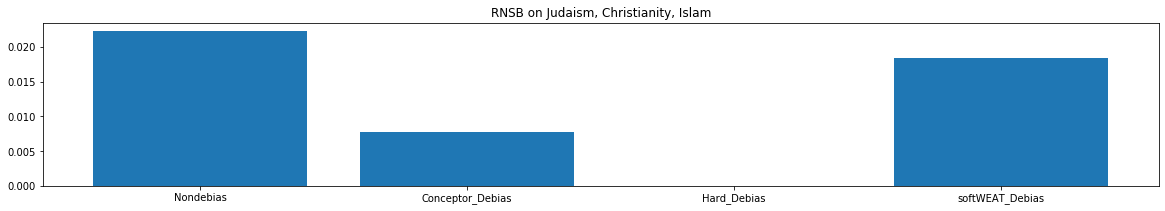

In [58]:
RNSB = [d[0] for d in Results.values()]
for key, value in Results.items():
    print(f' {key} : {value[0]}')
plt.figure(figsize=(20, 3))
plt.title('RNSB on Judaism, Christianity, Islam')
plt.bar(Results.keys(), RNSB)
plt.show()


 Nondebias : 0
 Conceptor_Debias : 0.03058744230543485
 Hard_Debias : 0.024471621311983733
 softWEAT_Debias : 0.05963003348674883


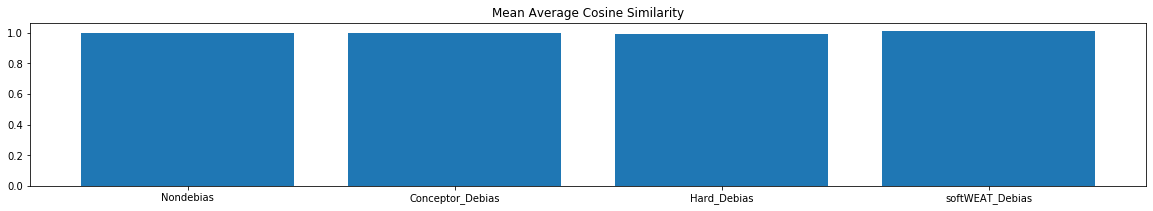

In [59]:
MAC = [d[2] for d in Results.values()]
for key, value in Results.items():
    print(f' {key} : {value[1]}')
plt.figure(figsize=(20, 3))
plt.title('Mean Average Cosine Similarity')
plt.bar(Results.keys(), MAC)
plt.show()


 Nondebias : 0.9951864821818667
 Conceptor_Debias : 0.9969530022943499
 Hard_Debias : 0.993761308398741
 softWEAT_Debias : 1.0136715176252593


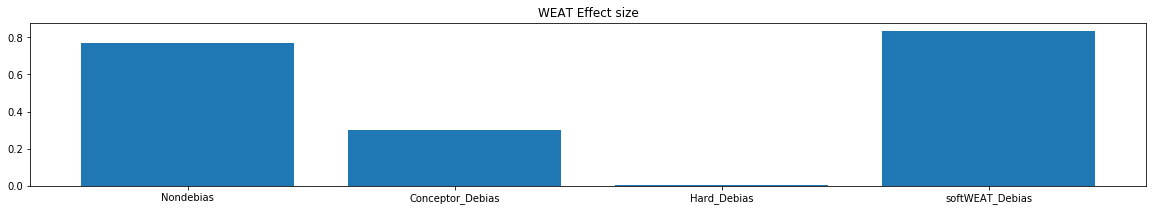

In [60]:
WEATD = [d[4] for d in Results.values()]
for key, value in Results.items():
    print(f' {key} : {value[2]}')
plt.figure(figsize=(20, 3))
plt.title('WEAT Effect size')
plt.bar(Results.keys(), WEATD)
plt.show()
